In [1]:
# import librosa.display
import librosa
import soundfile
import h5py, pickle
from tqdm import tqdm

from utils import *
from datasets import get_dataloaders
from decoders import get_CTC_decoder, Mycodec
from models import get_model
from jiwer import wer

import DALI as dali_code

import matplotlib.pyplot as plt
%matplotlib notebook
from IPython.display import Audio

def obtain_pitch_seqs(pitches, onsets, input_lengths):
    pitches = pitches.cpu().numpy()
    pitches = np.argmax(pitches, axis=-2)
    onsets = onsets.cpu().numpy()
    input_lengths = input_lengths.cpu().numpy()
    pitch_seqs = []
    target_lengths = []
    for i in range(len(input_lengths)):
        _, pitch_seq = formalize_to_intervals(pitches[i, :input_lengths[i]], onsets[i, :input_lengths[i]])
        pitch_seqs.extend(pitch_seq)
        target_lengths.append(len(pitch_seq))
    return torch.tensor(pitch_seqs, dtype=torch.long), torch.tensor(target_lengths, dtype=torch.long)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
DEVICE

'cuda'

In [3]:
fold = 0
epoch = 5
configs = read_yaml(f"./configs/train_baseline/RWC_pitch_cqt_1_1_2ch_tatum_fold{fold}.yaml") 
train_dataloaders, val_dataloaders, test_dataloaders = get_dataloaders(configs["dataloaders"])

model = {}
for model_name in configs["model"]:
    model[model_name] = get_model(num_classes_pitch=129, **configs["model"][model_name])

model['melody'].load_state_dict(torch.load(f"/n/work1/deng/workspaces/checkpoints/RWC-tatum/20220607/config=RWC_pitch_cqt_1_1_2ch_tatum_fold{fold}.yaml/melody/epoch={epoch}.pth"), strict=False)
for model_name in configs["model"]:
    model[model_name] = model[model_name].to(DEVICE).eval()

In [4]:
test_dataset = test_dataloaders["RWC_test"].dataset

In [5]:
i = 22
# i = 99


In [6]:
index_id = i // 25 if test_dataset.pitch_shift else i
track_id = test_dataset.indexes[index_id]['track_id']
tatum_ids = test_dataset.indexes[index_id]['tatum_ids']
hdf5_path = os.path.join(test_dataset.hdf5s_dir, f"p{track_id:0>3}.h5")
hdf5s_dir_sep = test_dataset.hdf5s_dir[:test_dataset.hdf5s_dir.rfind(".")] + "_separated" + test_dataset.hdf5s_dir[test_dataset.hdf5s_dir.rfind("."):]
hdf5_path_sep = os.path.join(hdf5s_dir_sep, f"p{track_id:0>3}.h5")

In [7]:
with h5py.File(hdf5_path, 'r') as hf:
    with h5py.File(hdf5_path_sep, 'r') as hf_sep:
        sr = hf.attrs['sample_rate']
        hop_length = hf.attrs['hop_length']
        pitch_shift = list(range(-12, 13))[i % 25] if test_dataset.pitch_shift else 0
        # waveform:
        samples = librosa.time_to_samples(hf['tatum_time'][tatum_ids], sr=sr)
        frames = librosa.time_to_frames(hf['tatum_time'][tatum_ids], sr=sr, hop_length=hop_length)
        if pitch_shift == 0:
            waveform_mix = hf['waveform'][samples[0]: samples[1]]
            waveform_sep = hf_sep['waveform'][samples[0]: samples[1]]
        else:
            waveform_mix = hf[f"waveform_shifted_{pitch_shift}"][samples[0]: samples[1]]
            waveform_sep = hf_sep[f"waveform_shifted_{pitch_shift}"][samples[0]: samples[1]]


In [8]:
data = test_dataloaders["RWC_test"].dataset[i]
audio_feature, pitch, onset, _, tatums = data
audio_features = audio_feature.unsqueeze(0).to(DEVICE)
tatum_frames = tatums.unsqueeze(0).to(DEVICE)

In [9]:
audio_features.shape, tatum_frames.shape

(torch.Size([1, 14, 120, 703]), torch.Size([1, 81]))

In [10]:
with torch.no_grad():
    output_melody = model['melody'](audio_features, tatum_frames)
    pitches_prob = torch.softmax(output_melody[:, :-1, :], dim=1)
    onsets_prob = torch.sigmoid(output_melody[:, -1, :])

pitches = pitch.unsqueeze(0)
onsets = onset.unsqueeze(0)
pitches = np.argmax(pitches.numpy(), axis=1)
onsets = peakpicking(onsets.numpy(), window_size=1, threshold=0.5)
input_lengths = [tatum_frames.shape[1]] * tatum_frames.shape[0]
pitches_pre = np.argmax(pitches_prob.cpu().numpy(), axis=1)
onsets_pre = peakpicking(onsets_prob.cpu().numpy(), window_size=1, threshold=0.5)
note_results = evaluate_notes(pitches, onsets, pitches_pre, onsets_pre, input_lengths, sr=16000, hop_length=256)

note_results[2], note_results[5], note_results[8]

(0.12121212121212122, 0.12121212121212122, 0.12121212121212122)

In [11]:
pitch_prob = pitches_prob[0].cpu().numpy()
onset_prob = onsets_prob[0].cpu().numpy()

pitch_pre = np.argmax(pitch_prob, axis=0)
pitch_pre = pitch_pre[np.diff(np.append(0, pitch_pre)) != 0]
pitch_pre = pitch_pre[pitch_pre != 0]

In [12]:
pitch

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [13]:
pitch_pre

array([128,  60, 128,  60, 128])

In [14]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


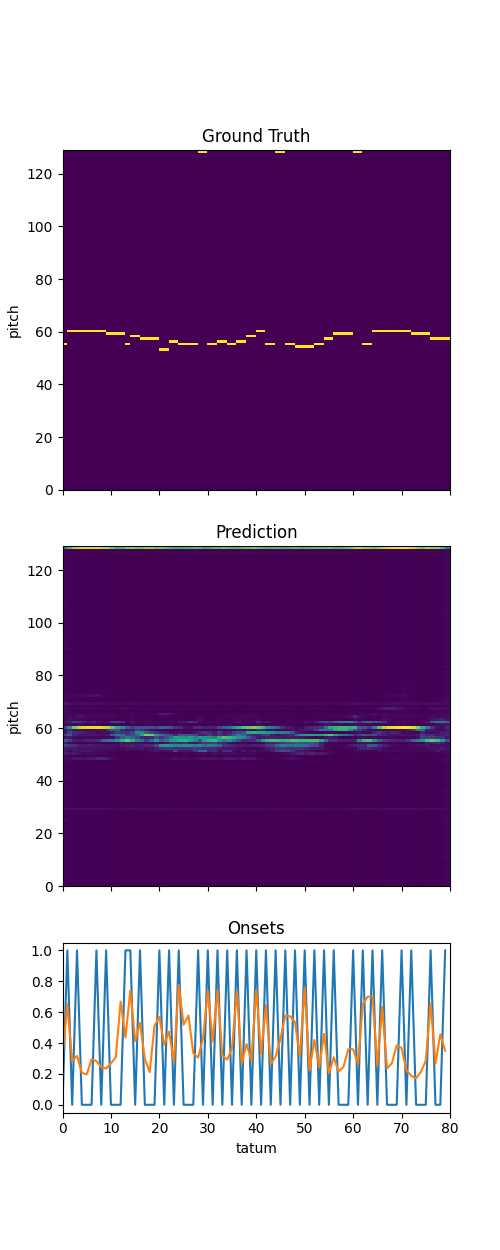

In [15]:
fig, ax = plt.subplots(nrows=3, sharex=True, 
                       figsize=(5,12.5), gridspec_kw={'height_ratios': [2, 2, 1]})

ax[0].pcolormesh(pitch)
ax[0].set_title("Ground Truth")
ax[0].set_ylabel("pitch")
ax[1].pcolormesh(pitch_prob)
ax[1].set_title("Prediction")
ax[1].set_ylabel("pitch")
ax[2].set_xlabel("tatum")
ax[2].plot(range(len(onset)), onset)
ax[2].plot(range(len(onset)), onset_prob)
ax[2].set_title("Onsets")
# ax[2].plot(range(len(onset)), onsets_pre[0])
plt.show()